# Calculating the dNBR

The dNBR or ΔNBR is the difference between two NBRs, calculated using data before and after the fire repectively.

- **TODO** Find this fire in the Waldbrandstatistik
- maybe helpful: German Wildire in Lübtheen 30 June 2019
  - https://web.archive.org/save/https://earth.esa.int/eogateway/news/german-wildfire

In [1]:
from pathlib import Path
import geopandas as gpd

# we can save some time by reading only parts of the product we are interested in
from rasterio.features import geometry_window

from sentinel_helpers import geodataframe_on_map, scihub_band_paths

In [2]:
nbr_path = Path('output/spectral_indices/')
product_path = Path('input/forest_fires/')

- we calculcated the nbr in another notebook

In [3]:
potsdam_mittelmark_nbr_2018 = list(sorted(nbr_path.glob('*2018*NBR*.tif')))
potsdam_mittelmark_nbr_2018

[PosixPath('output/spectral_indices/T33UUT_20180807T101021_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20180822T101019_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20180919T102021_NBR_10m.tif')]

In [4]:
potsdam_mittelmark_geom = gpd.read_file(product_path / 'evacuated_2018.json')
geodataframe_on_map(potsdam_mittelmark_geom)

- to calculate window sizes etc we need a plane instead of individual points
- we take the villages' locations and use them to construct a polygon

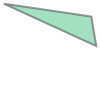

In [5]:
from shapely.geometry import Polygon
area_of_interest = Polygon(potsdam_mittelmark_geom['geometry'].values)
area_of_interest

## Calculate NBR / dNBR

- NBR is calculated in another notebook: [02 Spectral Indices.iypnb]
- We calculate dNBR (which is the difference between pre-fire NBR and post-fire NBR)

In [6]:
import matplotlib.pyplot as pplt
from sentinel_helpers import scihub_band_paths, RasterReaderList
import rasterio as r
import rasterio.plot as rplt

- We plot all of the calculated NBRs side by side

In [7]:
def plot_nbrs(products, geom):
    with RasterReaderList(products) as readers:
        fig, axes = pplt.subplots(nrows=1, ncols=3, figsize=(15, 15))

        # we need to reproject from WGS84 so the geometry can be correctly plotted on the map
        _geom = geom.to_crs(readers[0].crs)

        # we don't need the entire NBR, we only use a slice
        window = geometry_window(readers[0], _geom.buffer(5000))
        window_transform = readers[0].window_transform(window)

        for reader, ax in zip(readers, axes):
            nbr = reader.read(masked=True, window=window)
            rplt.show(nbr, ax=ax, transform=window_transform)
            _geom.plot(ax=ax, facecolor='none', edgecolor='red')

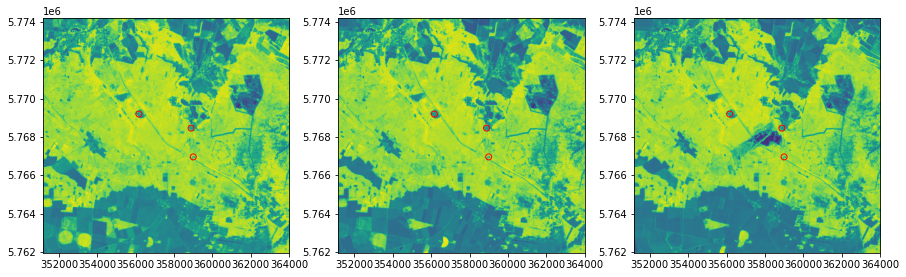

In [8]:
plot_nbrs(potsdam_mittelmark_nbr_2018, potsdam_mittelmark_geom)

- join cloud masks

- Calculate dNBR ($pre - post$)

In [9]:
def calculate_dnbr(pre_nbr, post_nbr, geom=[]):
    with RasterReaderList([pre_nbr, post_nbr]) as readers:
        if len(geom):
            # if a geometry is passed, perform all calculations only in the
            # surroundings if this geometry
            _geom = geom.to_crs(readers[0].crs)
            window = geometry_window(readers[0], _geom.buffer(5000))
            window_transform = readers[0].window_transform(window)
        else:
            window = window_transform = None
        
        pre_fire = readers[0].read(masked=True, window=window)
        post_fire = readers[1].read(masked=True, window=window)

        # we need to mask invalid pixels in any of the input files for the resulting file
        dnbr = pre_fire - post_fire
        dnbr.mask = pre_fire.mask | post_fire.mask
        
        return (dnbr, window, window_transform)

In [10]:
def plot_dnbr(dnbr, dnbr_crs, dnbr_transform, geom):
    fig, ax = pplt.subplots(figsize=(10, 10))
    _geom = geom.to_crs(dnbr_crs)

    rplt.show(dnbr, ax=ax, transform=dnbr_transform)
    _geom.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.colorbar(ax.get_images()[0], shrink=0.5)

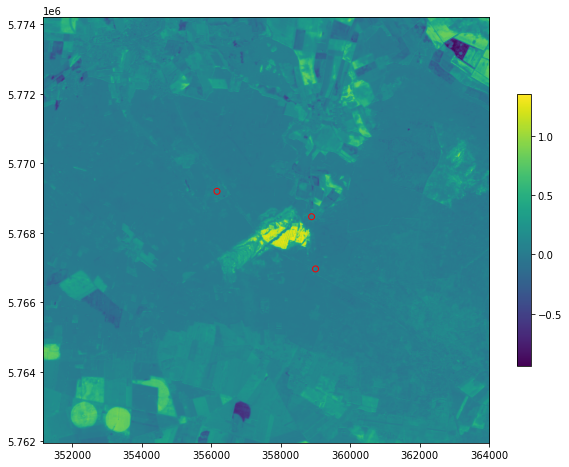

In [11]:
with r.open(potsdam_mittelmark_nbr_2018[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(potsdam_mittelmark_nbr_2018[0], potsdam_mittelmark_nbr_2018[2], potsdam_mittelmark_geom)
plot_dnbr(dnbr, src.crs, window_transform, potsdam_mittelmark_geom)

## 2019

In [12]:
jueterbog_geom = gpd.read_file(product_path / 'jueterbog_2019.json')
jueterbog_nbr_2019 = list(sorted(nbr_path.glob('T33UUT*201906*NBR*.tif')))
jueterbog_nbr_2019

[PosixPath('output/spectral_indices/T33UUT_20190603T101031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20190613T101031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20190626T102031_NBR_10m.tif')]

In [13]:
jueterbog_geom = gpd.read_file(product_path / 'jueterbog_2019.json')
geodataframe_on_map(jueterbog_geom)

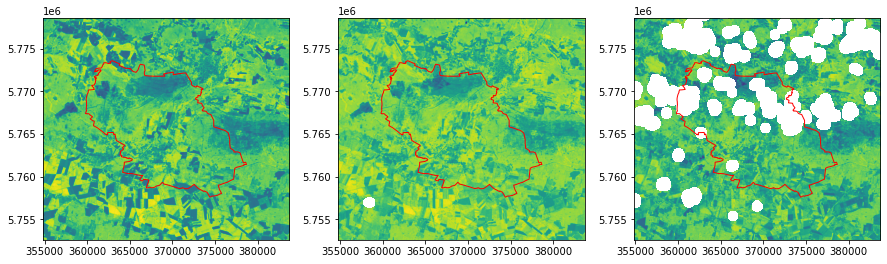

In [14]:
plot_nbrs(jueterbog_nbr_2019, jueterbog_geom)

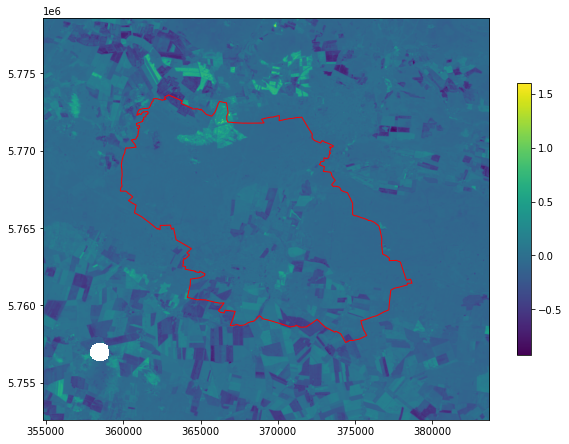

In [15]:
with r.open(jueterbog_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(jueterbog_nbr_2019[0], jueterbog_nbr_2019[1], jueterbog_geom)
plot_dnbr(dnbr, src.crs, window_transform, jueterbog_geom)

### Lübtheen

In [16]:
luebtheen_geom = gpd.read_file(product_path / 'luebtheen_2019.json')
luebtheen_nbr_2019 = list(sorted(nbr_path.glob('T32UPE_2019*.tif')))
luebtheen_nbr_2019

[PosixPath('output/spectral_indices/T32UPE_20190629T103031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T32UPE_20190701T102029_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T32UPE_20190726T102031_NBR_10m.tif')]

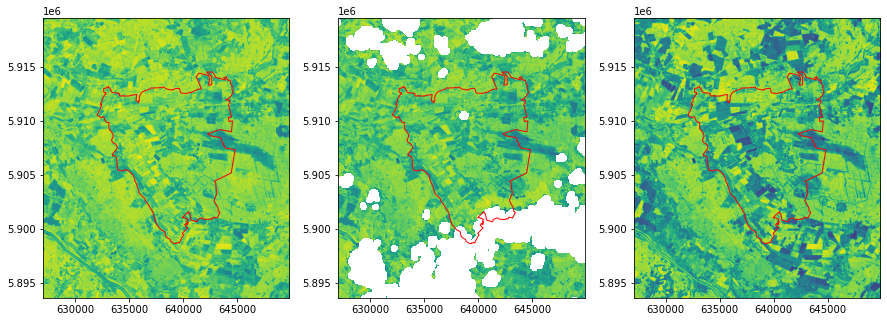

In [17]:
plot_nbrs(luebtheen_nbr_2019, luebtheen_geom)

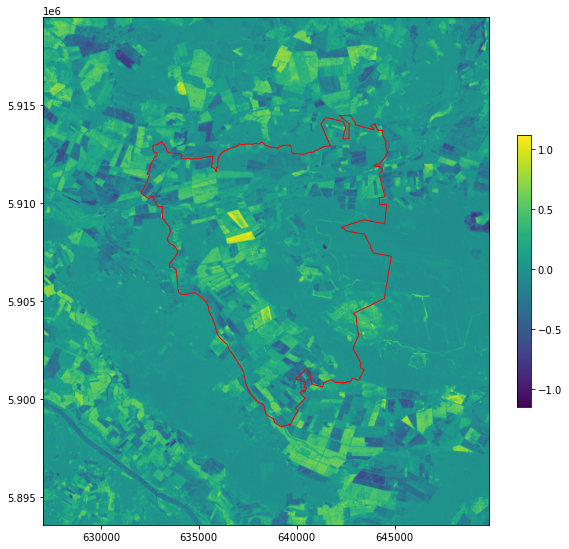

In [18]:
with r.open(luebtheen_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(luebtheen_nbr_2019[0], luebtheen_nbr_2019[2], luebtheen_geom)
plot_dnbr(dnbr, src.crs, window_transform, luebtheen_geom)

- we do the same with moderate severity

In [19]:
luebtheen_esa_pre_fire = Path('input/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip')
luebtheen_esa_active_fire = Path('input/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip')
luebtheen_esa_post_fire = Path('input/forest_fires/S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_20190726T125507.zip')

In [20]:
from shapely.geometry import box

def preview_true_color(product_zip_path, geometry):
    with r.open(scihub_band_paths(product_zip_path, ['TCI'], '60m')[0]) as src:
        fig, ax = pplt.subplots(figsize=(10,10))
        _geom = geometry.to_crs(src.crs)
        
        window = geometry_window(src, _geom.buffer(5000))
        window_transform = src.window_transform(window)
        
        rplt.show(src.read(window=window), transform=window_transform, ax=ax)
        _geom.plot(ax=ax, facecolor='none', edgecolor='red')

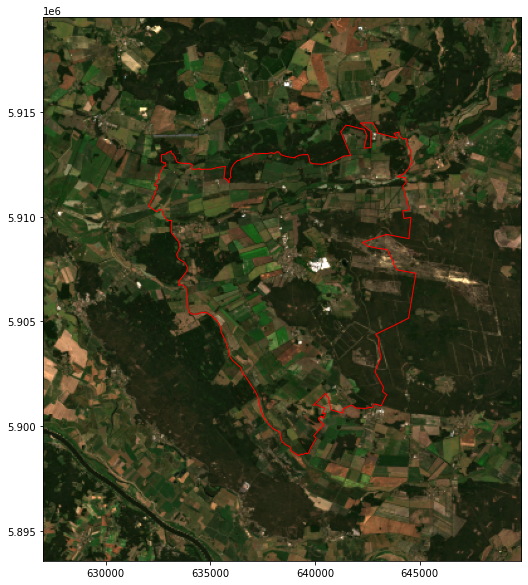

In [21]:
preview_true_color(luebtheen_esa_pre_fire, luebtheen_geom)

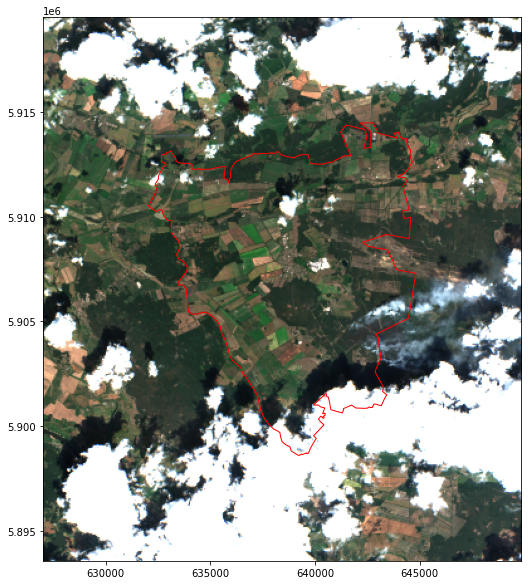

In [22]:
preview_true_color(luebtheen_esa_active_fire, luebtheen_geom)

- **TODO** Fire is in the bottom right of the red shape

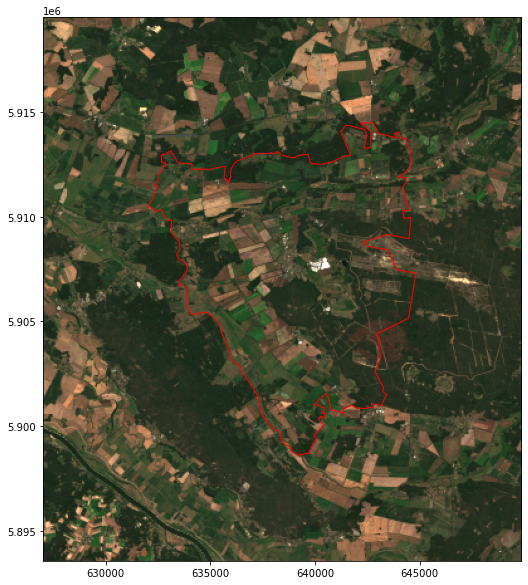

In [23]:
preview_true_color(luebtheen_esa_post_fire, luebtheen_geom)